In [1]:
import os
import math
from collections import defaultdict
from typing import List 

import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter

color_pallette = 'muted'
sns.set_theme(style='whitegrid', font_scale=1.5, palette=color_pallette, 
              rc={'font.family':'serif', 'font.serif':'Times New Roman'})

In [2]:
PROJECT_FOLDER = os.path.dirname(os.path.abspath(''))
DATA_FOLDER = os.path.join(PROJECT_FOLDER, 'data')

KB = float(1024)
MB = float(KB ** 2)
SECUNDS_IN_MINUTE = 60

titlesize = 16

cols_to_display = ['task_name', 'model_name', 'accuracy', 'macro avg_f1-score', 'macro avg_recall', 
                   'macro avg_precision', 'training_time', 'eval_time',
                   'model_size [MB]', 'memory [MB]', 'parameters']

def manage_model_name(name: str) -> str:
    spl = name.split('/')
    if len(spl) == 2:
        return spl[1]
    else:
        return name

def load_results_df(file_path: str):
    df = pd.read_csv(file_path)
    df['model_name'] = df['model_name'].apply(lambda x: manage_model_name(x))
    
    df['model_size [MB]'] = df['model_size']/MB
    df['memory [MB]'] = df['memory']/MB
    df['training_time_in_minutes'] = df['training_time']/SECUNDS_IN_MINUTE
    return df

def visualize_models(df: pd.DataFrame, models: List[str], suptitle: str = ''):
        
    df = df[df['model_name'].isin(models)].copy()
    
    fig = plt.figure(figsize=(12, 10), constrained_layout=True)
    gs = fig.add_gridspec(3, 6)
    
    # Plot measures
    ax1 = fig.add_subplot(gs[0, :])
    
    id_cols = ['name', 'model_name', 'task_name']   
    measures_to_plot = ['accuracy', 'macro avg_f1-score', 'macro avg_recall', 
                    'macro avg_precision']
    df_measures = pd.melt(df, id_vars=id_cols, value_vars=measures_to_plot)
    
    x_ticks_labels = [col.replace('_',' ').replace('-',' ').capitalize()
                      for col in measures_to_plot]
        
    sns.barplot(x='variable', y='value', hue='model_name', hue_order=models, edgecolor="0",
                ci='sd', errwidth=1.25, capsize=0.075, data=df_measures, ax=ax1)
    
    if len(models) < 3:
        y_offset = 0.003
        x_offset = 0.1
        for p in ax1.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + y_offset
            value = f'{100*p.get_height():.1f}%'
            ax1.text(_x, _y, value, ha="center") 

    ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    ax1.set_ylim(bottom=df_measures['value'].min()-0.02)
    ax1.set_xticklabels(x_ticks_labels)
    ax1.set_xlabel('Measure')
    ax1.set_title('Results', fontsize=titlesize)
    ax1.set_ylabel('Value')
    
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, title='Model', bbox_to_anchor=(1.02, 0.9), loc=2, borderaxespad=0.)
    ax1.get_legend().remove()
    
    # Plot training times
    ax2 = fig.add_subplot(gs[1, :3])
    plot_varaible(df, y='training_time_in_minutes', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Time [min]', title ='Training time', ax=ax2, ci=None)
    
    # Plot eval times
    ax3 = fig.add_subplot(gs[1, 3:])
    plot_varaible(df, y='eval_time', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Time [s]', title = 'Eval time', ax=ax3, ci=None)
    
    # Plot model size
    ax4 = fig.add_subplot(gs[2, :2])   
    plot_varaible(df, y='model_size [MB]', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Size [MB]', title = 'Size on drive', ax=ax4)
    
    # Plot memory usage
    ax5 = fig.add_subplot(gs[2, 2:4])   
    plot_varaible(df, y='memory [MB]', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Memory [MB]', title = 'Memory usage', ax=ax5)
    
    # Plot model size
    ax6 = fig.add_subplot(gs[2, 4:])   
    plot_varaible(df, y='parameters', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Parameters', title = 'Parameters', ax=ax6, formatter=FuncFormatter(millions))
    
    fig.suptitle(suptitle)
#     fig.tight_layout()   
#     file_name = suptitle.replace(':', '').replace(' ','-') + '.pdf'
#     fig.savefig(file_name, bbox_inches='tight')


def visualize_models_comparision(df: pd.DataFrame, reference_model: str, models: List[str], suptitle: str = ''):
    cols = ['task_name', 'model_name', 'accuracy', 'macro avg_f1-score', 'macro avg_recall', 'macro avg_precision',
     'training_time_in_minutes', 'eval_time',
        'model_size [MB]', 'memory [MB]', 'parameters']
    
    df = df[df['model_name'].isin(models + [reference_model])].copy()[cols]
    values_for_ref = {c: df[df['model_name'] == reference_model][c].values[0] for c in df.columns}
    
    measures = ['accuracy', 'macro avg_f1-score', 'macro avg_recall', 'macro avg_precision']
    for measure in measures:    
        df[measure + '_diff'] = df[measure].apply(lambda x: x - values_for_ref[measure])
        
    for time_measure in ['training_time_in_minutes', 'eval_time']:    
        df[time_measure + '_speedup'] = df[time_measure].apply(lambda x: values_for_ref[time_measure] / x)
        
    for size_measure in ['model_size [MB]', 'memory [MB]', 'parameters']:    
        df[size_measure + '_compression'] = df[size_measure].apply(lambda x: values_for_ref[size_measure] / x)

#     display(df)
    
    fig = plt.figure(figsize=(12, 10), constrained_layout=True)
    gs = fig.add_gridspec(3, 6)
    
    palette = np.array(sns.color_palette(color_pallette))[1:]
    
    # Plot measures
    ax1 = fig.add_subplot(gs[0, :])
    
    id_cols = ['model_name']   
    measures_to_plot = [m + '_diff' for m in measures]
    df_measures = pd.melt(df, id_vars=id_cols, value_vars=measures_to_plot)
        
    x_ticks_labels = [col.replace('_',' ').replace('-',' ').capitalize() for col in measures_to_plot]
    sns.barplot(x='variable', y='value', hue='model_name', hue_order=models, edgecolor="0", data=df_measures, ax=ax1,
                palette=palette, ci=None)
    
    ax1.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    ax1.set_xticklabels(x_ticks_labels)
    ax1.set_xlabel('Measure')
    ax1.set_title('Results', fontsize=titlesize)
    ax1.set_ylabel('Value')
    
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, title='Model', bbox_to_anchor=(1.02, 0.9), loc=2, borderaxespad=0.)
    ax1.get_legend().remove()
    
    # Plot training times
    ax2 = fig.add_subplot(gs[1, :3])
    plot_varaible(df, y='training_time_in_minutes_speedup', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Speedup', title ='Training time', ax=ax2, ci=None, palette=palette)
    
    # Plot eval times
    ax3 = fig.add_subplot(gs[1, 3:])
    plot_varaible(df, y='eval_time_speedup', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Speedup', title = 'Eval time', ax=ax3, ci=None, palette=palette)
    
    # Plot model size
    ax4 = fig.add_subplot(gs[2, :2])   
    plot_varaible(df, y='model_size [MB]_compression', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Compresion ratio', title = 'Size on drive', ax=ax4, palette=palette)
    
    # Plot memory usage
    ax5 = fig.add_subplot(gs[2, 2:4])   
    plot_varaible(df, y='memory [MB]_compression', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Compresion ratio', title = 'Memory usage', ax=ax5, palette=palette)
    
    # Plot model size
    ax6 = fig.add_subplot(gs[2, 4:])   
    plot_varaible(df, y='parameters_compression', x='model_name', order=models, remove_xticks=True,
                  xlabel='Model', ylabel='Compresion ratio', title = 'Parameters', ax=ax6, palette=palette)
    
    fig.suptitle(suptitle)

     
def plot_varaible(data, x, y, order, title='', remove_xticks=False,
                  xlabel=None, ylabel=None, ax=None, formatter=None, **kwargs):
    ax = sns.barplot(x=x, y=y, order=order, data=data, edgecolor="0", ax=ax, **kwargs)
    
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
    if remove_xticks:   
        ax.set_xticklabels([])
    if formatter:
        ax.yaxis.set_major_formatter(formatter)
        
    ax.set_title(title, fontsize=titlesize)
    
    lim_offset = 0.2
    bar_width = 1

    change_width(ax, bar_width)
    left, right = ax.get_xlim()
    ax.set_xlim(left=left-lim_offset, right=right+lim_offset)
    
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value)                     # we change the bar width
        patch.set_x(patch.get_x() + diff * .5)         # we recenter the bar
    
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.0fM' % (x * 1e-6)

# Multiemo EN - All sentences

In [3]:
file_name = 'new_results-multiemo_en_all_sentence.csv'
file_path = os.path.join(DATA_FOLDER, file_name)

df_base = load_results_df(file_path)


In [4]:
file_name = 'results-bert-of-theseus-multiemo_en_all_sentence.csv'
file_path = os.path.join(DATA_FOLDER, file_name)
df_theseus = load_results_df(file_path)

df_theseus = df_theseus.rename(columns={'per_gpu_train_batch_size': 'batch_size', 'num_train_epochs': 'epochs'})

columns_to_drop = set(df_theseus.columns) - set(df_base.columns)
df_theseus = df_theseus.drop(columns=columns_to_drop)

In [5]:
df = pd.concat([df_base, df_theseus], ignore_index=True)
with pd.option_context('display.max_columns', None):
    display(df.head(5))

,name,model_name,task_name,epochs,batch_size,learning_rate,weight_decay,warmup_steps,max_seq_length,do_lower_case,training_time,accuracy,eval_time,z_amb_precision,z_amb_recall,z_amb_f1-score,z_amb_support,z_minus_m_precision,z_minus_m_recall,z_minus_m_f1-score,z_minus_m_support,z_plus_m_precision,z_plus_m_recall,z_plus_m_f1-score,z_plus_m_support,z_zero_precision,z_zero_recall,z_zero_f1-score,z_zero_support,macro avg_precision,macro avg_recall,macro avg_f1-score,macro avg_support,weighted avg_precision,weighted avg_recall,weighted avg_f1-score,weighted avg_support,model_size,memory,parameters,model_size [MB],memory [MB],training_time_in_minutes
0,multiemo_en_all_sentence-run-1,bert-base-uncased,multiemo_en_all_sentence,4.0,16,0.00005,0.01,0,128,True,1537.315493,0.790078,13.733866,0.615809,0.491924,0.546939,681,0.821263,0.833255,0.827215,2123,0.803067,0.860053,0.830584,1522,0.794637,0.793517,0.794076,1419,0.758694,0.744687,0.749704,5745,0.785512,0.790078,0.786699,5745,438025389,437945360,109485316,417.733563,417.657242,25.621925
1,multiemo_en_all_sentence-run-2,bert-base-uncased,multiemo_en_all_sentence,4.0,16,0.00005,0.01,0,128,True,1611.987581,0.790426,14.166007,0.551336,0.575624,0.563218,681,0.823199,0.829016,0.826097,2123,0.828999,0.837714,0.833333,1522,0.820324,0.785060,0.802305,1419,0.755965,0.756853,0.756238,5745,0.791799,0.790426,0.790976,5745,438025389,437945360,109485316,417.733563,417.657242,26.866460
2,multiemo_en_all_sentence-run-3,bert-base-uncased,multiemo_en_all_sentence,4.0,16,0.00005,0.01,0,128,True,1572.489301,0.790426,14.042586,0.633136,0.471366,0.540404,681,0.792599,0.867640,0.828424,2123,0.837838,0.814717,0.826116,1522,0.793584,0.801973,0.797757,1419,0.764289,0.738924,0.748175,5745,0.785925,0.790426,0.786096,5745,438025389,437945360,109485316,417.733563,417.657242,26.208155
3,multiemo_en_all_sentence-run-4,bert-base-uncased,multiemo_en_all_sentence,4.0,16,0.00005,0.01,0,128,True,1549.963947,0.784508,13.747969,0.626866,0.431718,0.511304,681,0.772614,0.877061,0.821531,2123,0.812899,0.836399,0.824482,1522,0.829231,0.759690,0.792939,1419,0.760402,0.726217,0.737564,5745,0.779994,0.784508,0.778477,5745,438025389,437945360,109485316,417.733563,417.657242,25.832732
4,multiemo_en_all_sentence-run-5,bert-base-uncased,multiemo_en_all_sentence,4.0,16,0.00005,0.01,0,128,True,1551.794576,0.786771,13.746088,0.555916,0.503671,0.528505,681,0.797975,0.853980,0.825028,2123,0.833224,0.833771,0.833498,1522,0.821455,0.771670,0.795785,1419,0.752143,0.740773,0.745704,5745,0.784420,0.786771,0.784900,5745,438025389,437945360,109485316,417.733563,417.657242,25.863243


In [6]:
df[['model_name', 'training_time', 'training_time_in_minutes', 'eval_time']]

,model_name,training_time,training_time_in_minutes,eval_time
0,bert-base-uncased,1537.315493,25.621925,13.733866
1,bert-base-uncased,1611.987581,26.866460,14.166007
2,bert-base-uncased,1572.489301,26.208155,14.042586
3,bert-base-uncased,1549.963947,25.832732,13.747969
4,bert-base-uncased,1551.794576,25.863243,13.746088
5,bert-base-uncased,1543.004341,25.716739,13.754082
6,distilbert-base-uncased,839.422403,13.990373,6.934964
7,distilbert-base-uncased,844.192825,14.069880,7.087827
8,distilbert-base-uncased,839.888947,13.998149,7.040409
9,distilbert-base-uncased,849.278980,14.154650,6.910358


In [16]:
# df.info()

In [17]:
# df['model_name'].values

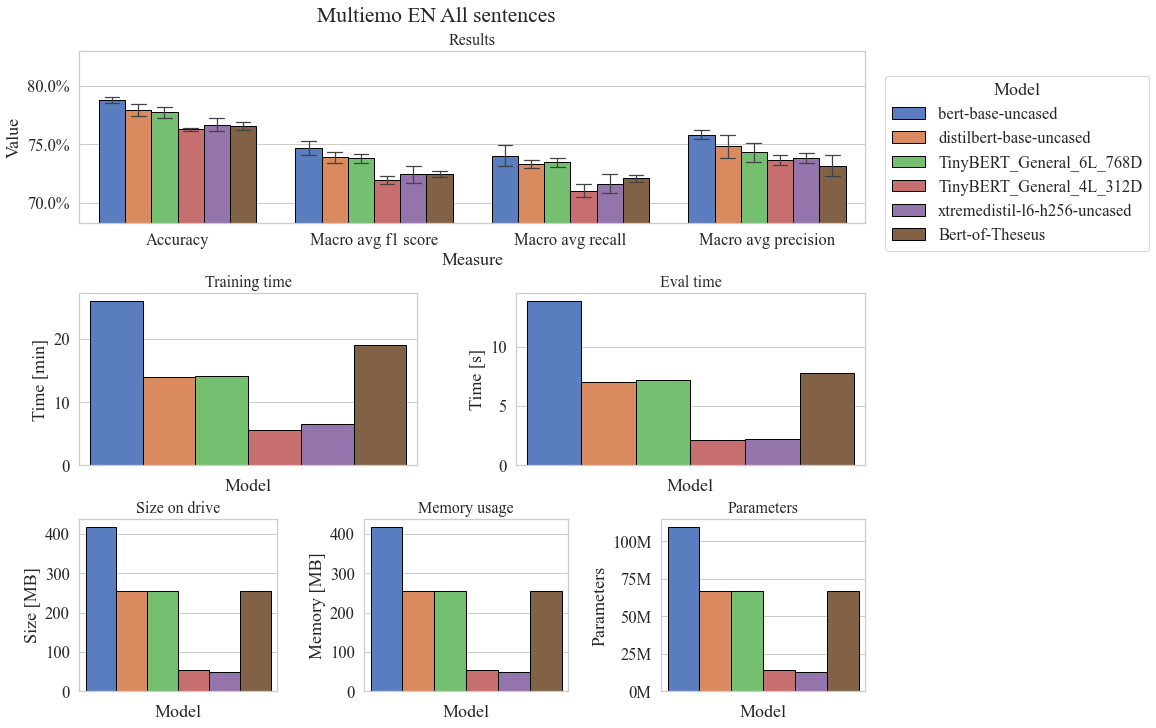

In [14]:
models = ['bert-base-uncased', 'distilbert-base-uncased','TinyBERT_General_6L_768D',
          'TinyBERT_General_4L_312D','xtremedistil-l6-h256-uncased', 'Bert-of-Theseus']
visualize_models(df, models, suptitle='Multiemo EN All sentences')

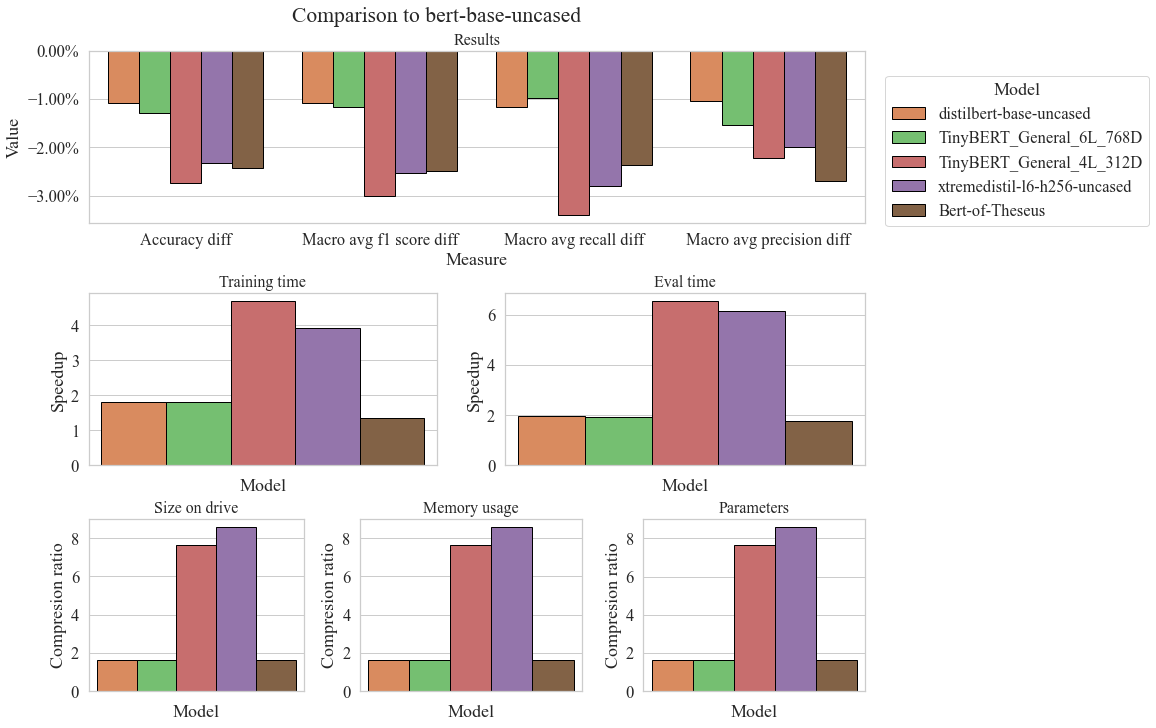

In [15]:
ref_model = 'bert-base-uncased'
models = ['distilbert-base-uncased','TinyBERT_General_6L_768D',
          'TinyBERT_General_4L_312D','xtremedistil-l6-h256-uncased', 'Bert-of-Theseus'
         ]
visualize_models_comparision(df, ref_model, models, suptitle='Comparison to {}'.format(ref_model))